In [1]:
import numpy as np
import matplotlib.pyplot as plt

import collections
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.internal.parameter_properties import ParameterProperties
from tensorflow_probability.python.internal.tensor_util import convert_nonref_to_tensor

from scipy.stats import uniform, triang, arcsine, dgamma, norm
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score

tfd = tfp.distributions
tfb = tfp.bijectors
psd_kernels = tfp.math.psd_kernels

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

np.random.seed(42)

2023-01-13 15:06:53.905875: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-01-13 15:06:53.905939: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: tumpji2
2023-01-13 15:06:53.905946: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: tumpji2
2023-01-13 15:06:53.906114: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.108.3
2023-01-13 15:06:53.906138: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-01-13 15:06:53.906142: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.161.3 does not match DSO version 510.108.3 -- cannot find working devices in this configuration
2023-01-13 15:06:53.906389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFl

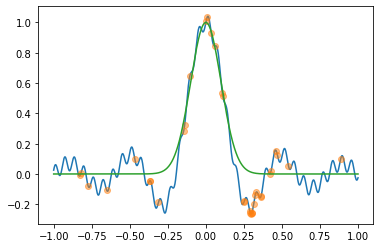

In [2]:
f = lambda x: np.sinc(x[..., -1]*5) + 0.05*np.sin(x[..., -1]*100)
N_train = 50

sample_distribution = dgamma(0.7, loc=0.3)

#true_distribution = uniform(-1, 1)
true_distribution = norm(0, 0.1)


observed_index_points = np.expand_dims(sample_distribution.rvs(N_train), -1)
observed_index_points = observed_index_points[observed_index_points[:,0] < 1]
observed_index_points = observed_index_points[observed_index_points[:,0] > -1]
observed_values = f(observed_index_points)

#observed_probability = 

x_test = np.linspace(-1, 1, 1000)[:, None]
y_test = f(x_test)

plt.plot(x_test, y_test)
plt.plot(observed_index_points, observed_values, '.', 
         markersize=12, alpha=0.5)
plt.plot(x_test, true_distribution.pdf(x_test) / max(true_distribution.pdf(x_test)))

In [3]:
# DATA AUG.
observed_index_points = np.concatenate(
    [observed_index_points, 
     true_distribution.logpdf(observed_index_points)
     #np.ones_like(observed_index_points)
    ], axis=1)

x_test = np.concatenate(
    [x_test, 
     true_distribution.logpdf(x_test)
     #np.ones_like(x_test)
    ], axis=1)

In [4]:
class MK3(psd_kernels.AutoCompositeTensorPsdKernel):
    def __init__(self,
            amplitude=None,
            length_scale=None,
            scale_mixture_rate=None,
            power_of_probability=None,
            feature_ndims=1,
            validate_args=False,
            name='RationalQuadraticPlus'):
        
            dtype = tf.float64
            #assert(feature_ndims >= 2)
        
            parameters = dict(locals())
            
            with tf.name_scope(name) as name:
                self._amplitude = convert_nonref_to_tensor(
                    amplitude, name='amplitude', dtype=dtype)
                self._length_scale = convert_nonref_to_tensor(
                    length_scale, name='length_scale', dtype=dtype)
                self._scale_mixture_rate = convert_nonref_to_tensor(
                    scale_mixture_rate, name='scale_mixture_rate', dtype=dtype)
                self._power_of_probability = convert_nonref_to_tensor(
                    power_of_probability, name='power_of_probability', dtype=dtype)
                
            super().__init__(
                feature_ndims, 
                dtype=dtype,
                name=name, 
                validate_args=validate_args,
                parameters=parameters)
            
    @property
    def length_scale(self):
        """Length scale parameter."""
        return self._length_scale
    
    @property
    def amplitude(self):
        """Length scale parameter."""
        return self._amplitude
    
    @property
    def scale_mixture_rate(self):
        """scale_mixture_rate parameter."""
        return self._scale_mixture_rate
    
    @property
    def power_of_probability(self):
        """scale_mixture_rate parameter."""
        return self._power_of_probability
    
    def _super_apply(self, x1, x2, example_ndims=1):
        pairwise_square_distance = tf.reduce_sum((x1 - x2)**2, axis=-1) 
        pairwise_square_distance /= 2
        pairwise_square_distance /= self.length_scale**2
        pairwise_square_distance /= self.scale_mixture_rate
        
        h = tf.math.log1p(pairwise_square_distance) * (-self.scale_mixture_rate)
        h += 2*tf.math.log(self.amplitude)
        return h
        
    def _apply(self, x1, x2, example_ndims=1):
        log_p1 = x1[..., -1]
        x1 = x1[..., 0:-1]
        log_p2 = x2[..., -1]
        x2 = x2[..., 0:-1]
        
        h = self._super_apply(x1, x2, example_ndims=example_ndims)
        
        is_diagonal = log_p1 - log_p2 < 10e-10
        is_not_diagonal = tf.logical_not(is_diagonal)
        
        is_diagonal = tf.cast(is_diagonal, tf.float64)
        is_not_diagonal = tf.cast(is_not_diagonal, tf.float64)
        
        is_diagonal = tf.stop_gradient(is_diagonal)
        is_not_diagonal = tf.stop_gradient(is_not_diagonal)
            
        h += (log_p1 + log_p2) * self.power_of_probability
        
        return tf.math.exp(h)
        
    
    @classmethod
    def _parameter_properties(cls, dtype):
        return dict(
            amplitude=ParameterProperties(
                default_constraining_bijector_fn=(
                    lambda: softplus.Softplus(low=dtype_util.eps(dtype)))),
            length_scale=ParameterProperties(
                default_constraining_bijector_fn=(
                    lambda: softplus.Softplus(low=dtype_util.eps(dtype)))),
            scale_mixture_rate=ParameterProperties(
                default_constraining_bijector_fn=(
                    lambda: softplus.Softplus(low=dtype_util.eps(dtype)))),
            power_of_probability=ParameterProperties()
        )

In [5]:
# VARS KERNEL:
amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    #trainable = False,
    bijector=constrain_positive,
    name='amplitude',
    dtype=tf.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    #trainable = False,
    bijector=constrain_positive,
    name='length_scale',
    dtype=tf.float64)
    
scale_mixture_rate_var = tfp.util.TransformedVariable(
    initial_value=1.,
    #trainable = False,
    bijector=constrain_positive,
    name='scale_mixture_rate',
    dtype=tf.float64
)

power_of_probability_var = tf.Variable(
    initial_value = 1.,
    #trainable = False,
    trainable = True,
    name = 'power_of_probability',
    dtype=tf.float64,
)

# VARS GP:
observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    #trainable=False,
    bijector=constrain_positive,
    name='observation_noise_variance',
    dtype=np.float64)


# KERNEL
kernel = MK3(
    length_scale=length_scale_var, 
    amplitude=amplitude_var,
    scale_mixture_rate=scale_mixture_rate_var,
    power_of_probability = power_of_probability_var,
    feature_ndims=1
)

# GP:
gp = tfd.GaussianProcess(
    kernel, 
    index_points=observed_index_points,
    observation_noise_variance=observation_noise_variance_var
)

optimizer = tf.optimizers.Adam(0.05)

if True:
    @tf.function
    def optimize():
        with tf.GradientTape() as tape:
            loss = -gp.log_prob(observed_values)
        grads = tape.gradient(loss, gp.trainable_variables)
        optimizer.apply_gradients(zip(grads, gp.trainable_variables))
        return loss
else:
    @tf.function
    def optimize():
        marginal_distribution = gp._get_marginal_distribution()
        
        with tf.GradientTape() as tape:
            loss = -gp.log_prob(observed_values)
        grads = tape.gradient(loss, gp.trainable_variables)
        optimizer.apply_gradients(zip(grads, gp.trainable_variables))
        return loss

for i in range(2000):
    neg_log_likelihood = optimize()
    if i % 100 == 0:
        print("Step {}: NLL = {}".format(i, neg_log_likelihood))
        
        #for v in gp.trainable_variables:
        #    print(f'{v.name}: {v.numpy()}')

Step 0: NLL = 34.850691352122006
Step 100: NLL = -16.043235823535063
Step 200: NLL = -16.057774952189888
Step 300: NLL = -16.058299010275405
Step 400: NLL = -16.05850331159438
Step 500: NLL = -16.05860874681599
Step 600: NLL = -16.05867159335812
Step 700: NLL = -16.058712602608438
Step 800: NLL = -16.05874109170005
Step 900: NLL = -16.058761816328897
Step 1000: NLL = -16.058777435800494
Step 1100: NLL = -16.058789542791786
Step 1200: NLL = -16.058799143771715
Step 1300: NLL = -16.05880690286002
Step 1400: NLL = -16.05881327416084
Step 1500: NLL = -16.05881857758915
Step 1600: NLL = -16.058823044327937
Step 1700: NLL = -16.058826845141475
Step 1800: NLL = -16.058830108597945
Step 1900: NLL = -16.058832933135555


------------------ parameters --------------- 
amplitude                     :	    -1.685 [+83.733%]
length_scale                  :	     4.660 [-343.257%]
power_of_probability          :	     1.253 [+25.322%]
scale_mixture_rate            :	    -1.186 [-113.638%]
observation_noise_variance    :	    -3.912 [-42.937%]
------------------ uniform --------------- 
Neg. log likelihood           :	   -16.059 [-58.836%]
MSE                           :	     0.010 [+226.401%]
MAE                           :	     0.081 [+78.917%]
Max Residual                  :	     0.269 [+66.358%]
R2                            :	     0.884 [-8.324%]
------------------ weighted --------------- 
MSE                           :	     0.005 [+104.783%]
MAE                           :	     0.054 [+38.674%]
Max Residual                  :	     0.001 [+9.305%]
R2                            :	     0.953 [-2.482%]


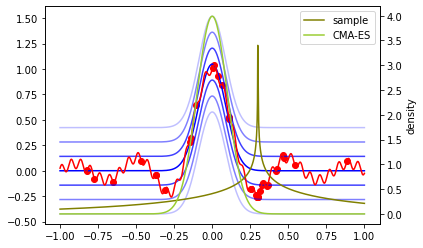

In [6]:
baseline_dict = collections.OrderedDict([('parameters',
              {'amplitude': -0.9168773348756537,
               'length_scale': -1.915615527464022,
               'power_of_probability': 1.0,
               'scale_mixture_rate': 8.696308515460158,
               'observation_noise_variance': -6.855668499677079}),
             ('uniform',
              {'Neg. log likelihood': -39.01157328516639,
               'MSE': 0.0031326061468591867,
               'MAE': 0.04521100283738582,
               'Max Residual': 0.16189268886203365,
               'R2': 0.9645374715379224}),
             ('weighted',
              {'MSE': 0.00229950979638076,
               'MAE': 0.039050717119097716,
               'Max Residual': 0.0006711507678900981,
               'R2': 0.976860822972481})])


gprm = tfd.GaussianProcessRegressionModel(
    # Batch of `num_results` kernels parameterized by the MCMC samples.
    kernel=gp.kernel,
    observation_noise_variance=gp.observation_noise_variance,
    observation_index_points=gp.index_points,
    observations=observed_values,
    index_points=x_test,
)

mean = gprm.mean().numpy()
var = gprm.variance().numpy()
std = np.sqrt(var)

params = gp.trainable_variables
        
w = true_distribution.pdf(x_test[:,0])
w /= np.sum(w)
me = np.max(w * np.abs(y_test - mean))
wnll = gprm

act_dict = collections.OrderedDict([
    ('parameters', {
        p.name[:-2]: float(p.numpy()) for p in gp.trainable_variables
    }),
    ('uniform', {
        'Neg. log likelihood': float(neg_log_likelihood.numpy()),
        'MSE': mean_squared_error(y_test, mean),
        'MAE': mean_absolute_error(y_test, mean),
        'Max Residual': max_error(y_test, mean),
        'R2': r2_score(y_test, mean)
    }),
    ('weighted', {
        "MSE": mean_squared_error(y_test, mean, sample_weight=w),
        "MAE": mean_absolute_error(y_test, mean, sample_weight=w),
        "Max Residual": me,
        "R2" : r2_score(y_test, mean, sample_weight=w)
    })
])
    
#print("-------------- parameters -----------------")
for paragraph_name, paragraph in act_dict.items():
    print(f"------------------ {paragraph_name} --------------- ")
    for name, value in paragraph.items():
        if paragraph_name in baseline_dict and name in baseline_dict[paragraph_name]:
            bl = baseline_dict[paragraph_name][name]
            ratio = ((value - bl) / bl)
            print(f"{name:<30}:\t{value:>10.03f} [{ratio*100:+.3f}%]")
        else:
            print(f"{name:<30}:\t{value:>10.03f}")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('density')
    
# gp
ax1.plot(x_test[:,0], mean, color='b')
ax1.plot(x_test[:,0], mean + std, color='b', alpha=0.75)
ax1.plot(x_test[:,0], mean - std, color='b', alpha=0.75)
ax1.plot(x_test[:,0], mean + 2*std, color='b', alpha=0.5)
ax1.plot(x_test[:,0], mean - 2*std, color='b', alpha=0.5)
ax1.plot(x_test[:,0], mean + 3*std, color='b', alpha=0.25)
ax1.plot(x_test[:,0], mean - 3*std, color='b', alpha=0.25)

# function - true
ax1.plot(x_test[:,0], y_test, color='r')

# points - true
ax1.scatter(observed_index_points[:,0], observed_values, color='r')

# distribution - sample
ax2.plot(x_test[:,0], sample_distribution.pdf(x_test[:, 0]), color='olive', label='sample')

# distribution - CMA-ES
ax2.plot(x_test[:,0], true_distribution.pdf(x_test[:, 0]), color='yellowgreen', label='CMA-ES')

ax2.legend()